# Compare Visual with Musical interface - GLM

In [4]:
import os, glob
import numpy as np
import pandas as pd
from nilearn import plotting

from src.my_settings import settings
sett = settings()

In [5]:
music_path = '/Volumes/T7/BIDS-MUSICNF/derivatives/nilearn-glm'
visual_path = '/Volumes/T7/BIDS-INTERHEMISPHERIC-NF/derivatives/nilearn-glm'

In [6]:
# List all zmap nii.gz files
zmap_music_files = glob.glob(
    os.path.join(music_path,
        f"sub-*_task-nf_space-MNI152NLin2009cAsym_stat-z_con-MotorImageryOneTwo.nii.gz"
    )
)
zmap_music_files.sort()

zmap_visual_files = glob.glob(
    os.path.join(visual_path,
        f"sub-*_task-nf_stat-z_con-MotorImagery.nii.gz"
    )
)
zmap_visual_files.sort()

n_subjects_music = len(zmap_music_files)
n_subjects_visual = len(zmap_visual_files)
print(f"Found {n_subjects_music} music subjects and {n_subjects_visual} visual subjects")

Found 22 music subjects and 10 visual subjects


In [7]:
second_level_input = zmap_music_files + zmap_visual_files

In [8]:
condition_effect = np.hstack(([1] * n_subjects_music, [-1] * n_subjects_visual))
condition_effect

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

/opt/anaconda3/envs/musicnf-novelinterface/lib/python3.13/site-packages/nilearn/plotting/matrix_plotting.py:503: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Axes: label='conditions', ylabel='scan number'>

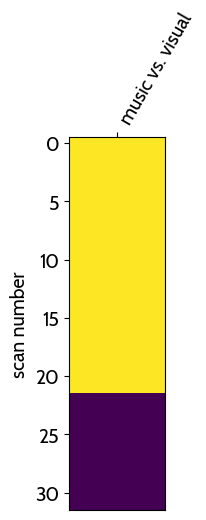

In [9]:
unpaired_design_matrix = pd.DataFrame(
    condition_effect[:, np.newaxis], columns=["music vs. visual"]
)

plotting.plot_design_matrix(
    unpaired_design_matrix, rescale=False
)

In [10]:
from nilearn.glm.second_level import SecondLevelModel
from nilearn.image import resample_to_img

# Resample images to the first image in the list
reference_img = second_level_input[0]
resampled_second_level_input = [resample_to_img(img, reference_img, interpolation='nearest') for img in second_level_input]

# Fit the second-level model with resampled images
second_level_model_unpaired = SecondLevelModel(n_jobs=2, smoothing_fwhm=8).fit(
    resampled_second_level_input, design_matrix=unpaired_design_matrix
)

stat_maps_unpaired = second_level_model_unpaired.compute_contrast(
    "music vs. visual", output_type="all"
)

Threshold: 4.578844908481699


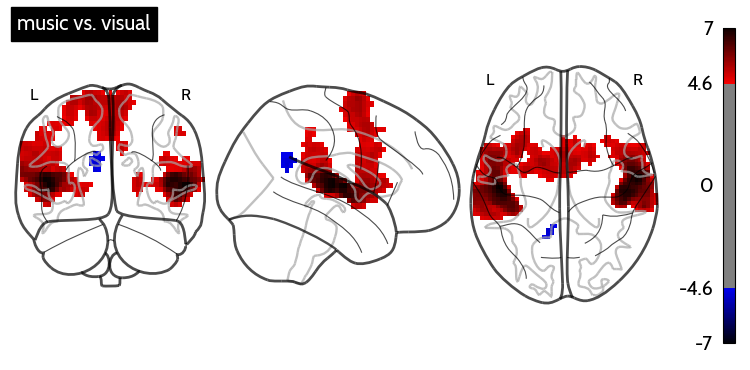

In [11]:
from nilearn.glm import threshold_stats_img

alpha = 0.0001
hc = 'fdr'
ct = 10

corrected_map, thres = threshold_stats_img(stat_maps_unpaired["z_score"], 
                                           cluster_threshold=ct, 
                                           alpha=alpha, 
                                           height_control=hc)

print(f"Threshold: {thres}")

display = plotting.plot_glass_brain(
    corrected_map,
    threshold=thres,
    colorbar=True,
    plot_abs=False,
    title="music vs. visual",
)

Music vs. Visual | Imagery | fdr(0.0001) | k>10


/opt/anaconda3/envs/musicnf-novelinterface/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:870: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



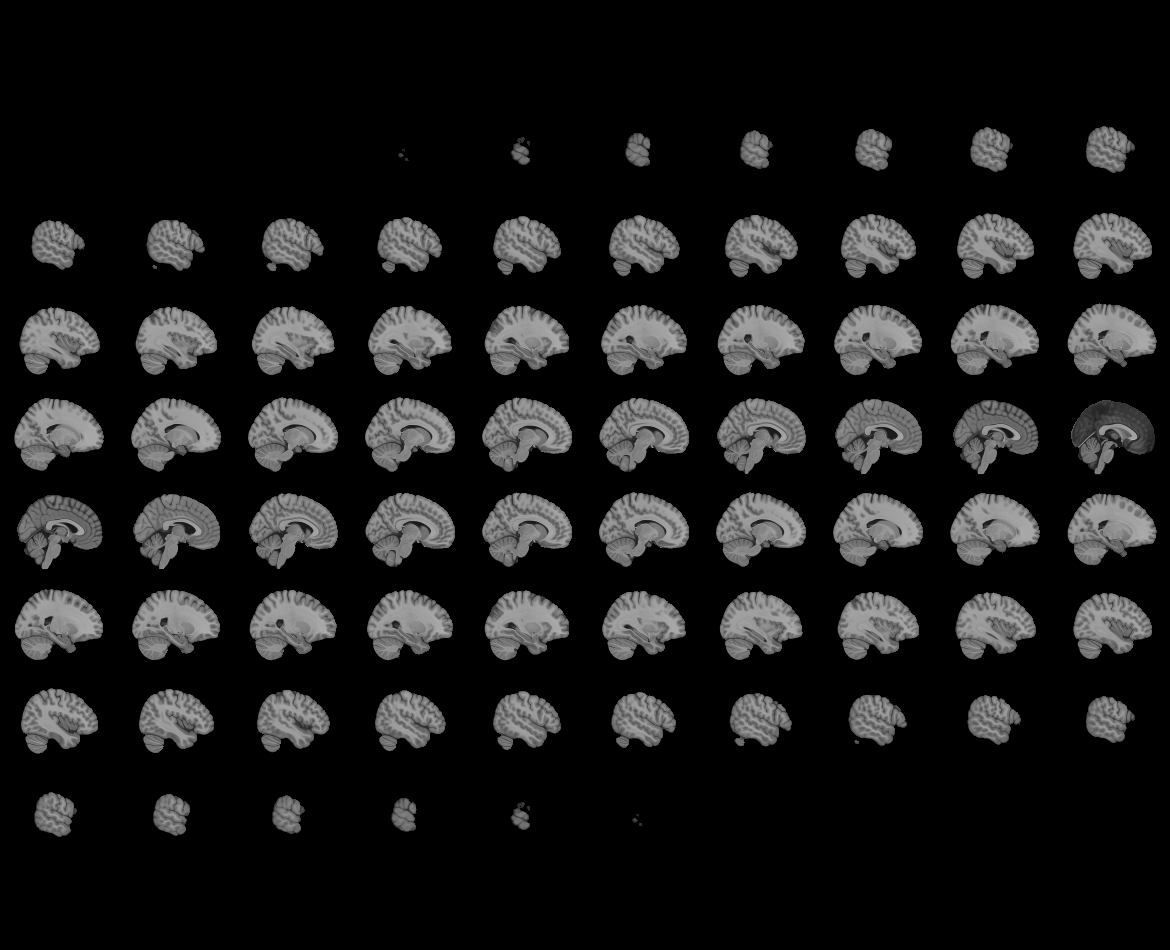
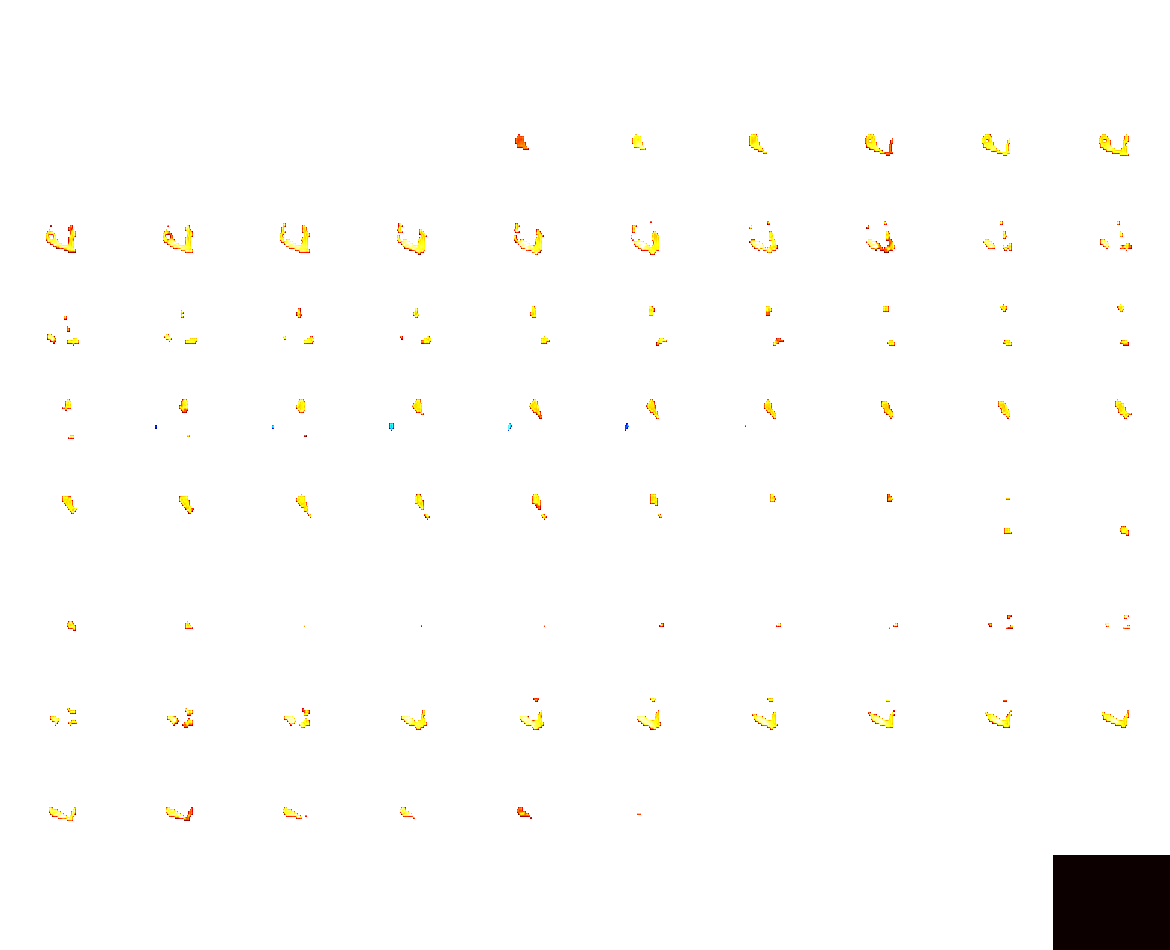

In [12]:
#| label: fig-musicVSvisual-glm-map
print(f"Music vs. Visual | Imagery | {hc}({alpha}) | k>{ct}")
plotting.view_img(corrected_map, threshold=thres, colorbar=True)

In [13]:
#| label: tab-musicVSvisual-glm-clusters
# cluster table
from nilearn.reporting import get_clusters_table
from mni_to_atlas import AtlasBrowser
atlas = AtlasBrowser("AAL3")

table = get_clusters_table(stat_maps_unpaired["z_score"], thres, cluster_threshold=ct)

# AAL3 labelling
coordinates = table[['X','Y','Z']].to_numpy()
aal_labels = atlas.find_regions(coordinates, plot=False)
table['AAL3'] = aal_labels
table

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3),AAL3
0,1,-51.0,-18.0,9.78,7.006895,37920,Temporal_Sup_L
1,1a,-54.0,-6.0,1.80,6.068404,,Temporal_Sup_L
2,1b,-57.0,3.0,1.80,5.844674,,Rolandic_Oper_L
3,1c,-36.0,12.0,1.80,5.445726,,Insula_L
4,2,60.0,-9.0,5.79,6.979855,22336,Heschl_R
5,2a,51.0,-21.0,9.78,6.774403,,Heschl_R
6,2b,63.0,-33.0,13.77,5.966451,,Temporal_Sup_R
7,2c,60.0,12.0,13.77,5.134725,,Frontal_Inf_Oper_R
8,3,-15.0,0.0,73.62,5.492893,18385,Frontal_Sup_2_L
9,3a,9.0,3.0,65.64,5.410758,,Supp_Motor_Area_R
